# Homenet
Skapar en session "spark".
_Notera att konfigurationen är uppdaterad med spark.sql.catalogImplementation = 'hive' vilket är en förutsättning för att kunna skapa permanenta tabeller._

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Homenet").config("spark.memory.offHeap.enabled", "true").config(
    "spark.memory.offHeap.size", "10g").config('spark.sql.catalogImplementation', 'hive').getOrCreate()

Läser in json-filerna för adresser, mäklare (individuella mäklare med ev info om vilka mäklarföretag de tillhör, om något), objekt (bostadsrätter) och personer (säljare och köpare).
Filerna läses först in till var sin dataframe, dataframen konverteras sedan till en temporär view - som man sedan kan ställa SQL-frågor till.

In [2]:
adresser = spark.read.json("spark-warehouse/adresser.json", multiLine=True)
adresser.createOrReplaceTempView("adresser")

maklare = spark.read.json("spark-warehouse/maklare.json", multiLine=True)
maklare.createOrReplaceTempView("maklare")

objekt = spark.read.json("spark-warehouse/objekt.json", multiLine=True)
objekt.createOrReplaceTempView("objekt")

personer = spark.read.json("spark-warehouse/personer.json", multiLine=True)
personer.createOrReplaceTempView("personer")

Så här kan man se schemat för en dataframe (eller temp view, eller tabell, etc) 

In [3]:
objekt.printSchema()

root
 |-- adress: long (nullable = true)
 |-- antal_rum: long (nullable = true)
 |-- avslutat: string (nullable = true)
 |-- balkong: string (nullable = true)
 |-- forsaljningspris: long (nullable = true)
 |-- hiss: string (nullable = true)
 |-- id: long (nullable = true)
 |-- kopare: long (nullable = true)
 |-- maklararvode: long (nullable = true)
 |-- maklare: long (nullable = true)
 |-- manadsavgift: long (nullable = true)
 |-- saljare: long (nullable = true)
 |-- saljstart: string (nullable = true)
 |-- storlek: long (nullable = true)
 |-- utgangspris: long (nullable = true)
 |-- vaning: long (nullable = true)


Så här kan man hämta ut datarader:

In [4]:
objekt.show(2,0)

+------+---------+----------+-------+----------------+----+---+------+------------+-------+------------+-------+----------+-------+-----------+------+
|adress|antal_rum|avslutat  |balkong|forsaljningspris|hiss|id |kopare|maklararvode|maklare|manadsavgift|saljare|saljstart |storlek|utgangspris|vaning|
+------+---------+----------+-------+----------------+----+---+------+------------+-------+------------+-------+----------+-------+-----------+------+
|75    |6        |2020-07-19|1      |14561000        |1   |1  |5     |218415      |2      |3090        |107    |2020-01-25|137    |12420000   |5     |
|72    |5        |2020-06-23|1      |5942500         |1   |2  |27    |89138       |5      |9044        |129    |2020-06-20|113    |5058000    |2     |
+------+---------+----------+-------+----------------+----+---+------+------------+-------+------------+-------+----------+-------+-----------+------+


Vi kan skriva SQL-queries:

In [5]:
result = spark.sql("SELECT * FROM personer LIMIT 5")
result.show()

+------+---------+--------------------+-------+---+----------+----------+
|adress|efternamn|               email|fornamn| id|  personnr| telefonnr|
+------+---------+--------------------+-------+---+----------+----------+
|   102| Wudeland|mwudeland0@drupal...|Danièle|  1|1997-12-19|3114705221|
|   104|   Prayer|jprayer1@wordpres...|    Zoé|  2|1958-02-26|6162426013|
|   106|  Dimmick|   hdimmick2@epa.gov|Thérèse|  3|1988-07-25|5095529405|
|   108| Cuddehay|scuddehay3@delici...| Noémie|  4|1962-08-23|3451506020|
|   110|   Cheley|ycheley4@shop-pro.jp|  André|  5|1976-12-26|6175439945|
+------+---------+--------------------+-------+---+----------+----------+


Våra queries kan göra joins mellan temp views (eller tabeller):

In [6]:
result = spark.sql("""
    SELECT * FROM objekt, personer 
        WHERE objekt.saljare = personer.id 
        LIMIT 5
""")
result.show()

+------+---------+----------+-------+----------------+----+---+------+------------+-------+------------+-------+----------+-------+-----------+------+------+-----------+--------------------+----------+---+----------+----------+
|adress|antal_rum|  avslutat|balkong|forsaljningspris|hiss| id|kopare|maklararvode|maklare|manadsavgift|saljare| saljstart|storlek|utgangspris|vaning|adress|  efternamn|               email|   fornamn| id|  personnr| telefonnr|
+------+---------+----------+-------+----------------+----+---+------+------------+-------+------------+-------+----------+-------+-----------+------+------+-----------+--------------------+----------+---+----------+----------+
|    75|        6|2020-07-19|      1|        14561000|   1|  1|     5|      218415|      2|        3090|    107|2020-01-25|    137|   12420000|     5|   153|Osbaldstone|eosbaldstone2y@ml...|Marie-noël|107|1976-05-11|3178324649|
|    72|        5|2020-06-23|      1|         5942500|   1|  2|    27|       89138|     

Vi kan skapa mer komplexa frågor, med UNIONs:
C. Vilken storlek på lägenheter säljer snabbast i Skåne? De som är under 50kvm, mellan 50-100kvm eller över 100kvm?

In [7]:
result = spark.sql("""
SELECT "Mindre än 50 kvm" AS storlek, ceil(avg(datediff(avslutat, saljstart))) AS dagar FROM objekt WHERE avslutat IS NOT NULL 
AND storlek < 50
UNION
SELECT "Mellan 50–100 kvm" AS storlek, ceil(avg(datediff(avslutat, saljstart))) AS dagar FROM objekt WHERE avslutat IS NOT NULL 
AND storlek BETWEEN 50 AND 100
UNION
SELECT "Större än 50 kvm" AS storlek, ceil(avg(datediff(avslutat, saljstart))) AS dagar FROM objekt WHERE avslutat IS NOT NULL 
AND storlek > 100
ORDER BY dagar LIMIT 1
""") 
result.show()

+-----------------+-----+
|          storlek|dagar|
+-----------------+-----+
|Mellan 50–100 kvm|  116|
+-----------------+-----+


Men om jag vill kunna skapa VIEWs behöver jag kunna göra queries mot permanenta tabeller. Och om jag vill spara egna permanenta SQL-tabeller eller spara dataframes permanent för SQL-querying, behöver jag konvertera mina dataframes (eller temp views) till tabeller:

In [ ]:
# Skapa en "hive table" (permanent tabell). 
# OBS! Notera att namnet på tabellen inte kan vara samma som min temp view: 
spark.sql("CREATE TABLE objekt_table AS SELECT * FROM objekt")

_(Notera att operationerna med att skapa hive-tabeller ger rätt mycket varningar, men fungerar ändå som de ska)_

Jag kan däremot ersätta min ursprungliga dataframe med en permanent tabell. Så här skulle det kunna se ut:

In [ ]:
# Läser in en JSON-fil till en dataframe
bostadsratter = spark.read.json("spark-warehouse/bostadsratter.json", multiLine=True)

# Skapa en temp-view
bostadsratter.createOrReplaceTempView("bostadsratter_temp_view")

# Skapa en hive-tabell från min temp-view
spark.sql("CREATE TABLE bostadsratter AS SELECT * FROM bostadsratter_temp_view")

In [ ]:
result = spark.sql("SELECT * FROM bostadsratter")
result.show(3,0)

Nu kan vi skapa VIEWs:

In [ ]:
spark.sql("CREATE OR REPLACE VIEW bostadsratter_till_forsaljning AS SELECT * FROM bostadsratter WHERE avslutat IS NOT NULL")

In [ ]:
result = spark.sql("SELECT * FROM bostadsratter_till_forsaljning")
result.show(3,0)

In [9]:
result = spark.sql("""
SELECT "Mindre än 50 kvm" AS storlek, ceil(avg(datediff(avslutat, saljstart))) AS dagar FROM objekt WHERE avslutat IS NOT NULL 
AND storlek < 50
UNION
SELECT "Mellan 50–100 kvm" AS storlek, ceil(avg(datediff(avslutat, saljstart))) AS dagar FROM objekt WHERE avslutat IS NOT NULL 
AND storlek BETWEEN 50 AND 100
UNION
SELECT "Större än 50 kvm" AS storlek, ceil(avg(datediff(avslutat, saljstart))) AS dagar FROM objekt WHERE avslutat IS NOT NULL 
AND storlek > 100
""") 
result.show()

+-----------------+-----+
|          storlek|dagar|
+-----------------+-----+
| Mindre än 50 kvm|  156|
|Mellan 50–100 kvm|  116|
| Större än 50 kvm|  135|
+-----------------+-----+


In [10]:
pandas_storlekar = result.toPandas()


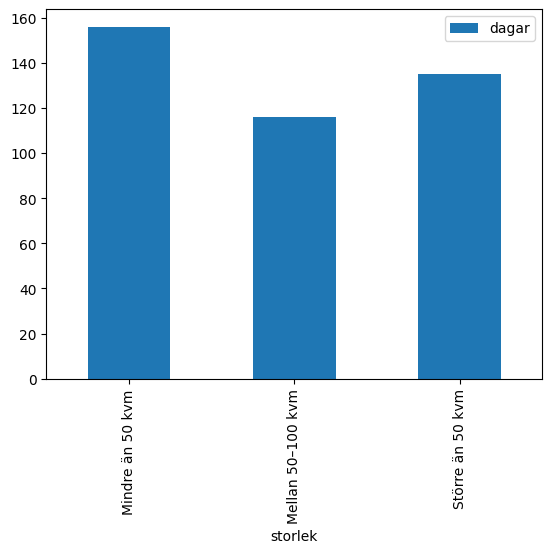

In [13]:
import matplotlib.pyplot as plt

# Simple bar plot
pandas_storlekar.plot(kind='bar', x='storlek', y='dagar')
plt.show()


In [34]:
maklarobjekt_view = spark.sql("SELECT CONCAT(YEAR(saljstart),'-',MONTH(saljstart)) AS manad, COUNT(id) AS nya_objekt FROM bostadsratter WHERE avslutat IS NOT NULL AND maklare IS NOT NULL GROUP BY YEAR(saljstart), MONTH(saljstart) ORDER BY YEAR(saljstart), MONTH(saljstart)")
maklarobjekt = maklarobjekt_view.toPandas()

In [35]:
privatobjekt_view = spark.sql("SELECT CONCAT(YEAR(saljstart),'-',MONTH(saljstart)) AS manad, COUNT(id) AS nya_objekt FROM bostadsratter WHERE avslutat IS NOT NULL AND maklare IS NULL GROUP BY YEAR(saljstart), MONTH(saljstart) ORDER BY YEAR(saljstart), MONTH(saljstart)")
privatobjekt = privatobjekt_view.toPandas()

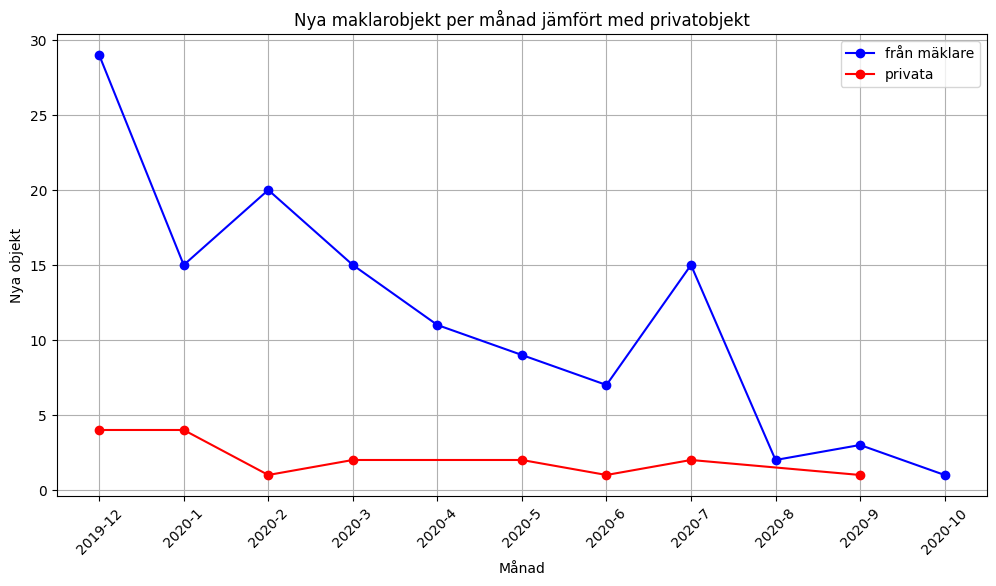

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(maklarobjekt['manad'], maklarobjekt['nya_objekt'], marker='o', linestyle='-', color='b', label='från mäklare')
plt.plot(privatobjekt['manad'], privatobjekt['nya_objekt'], marker='o', linestyle='-', color='r', label='privata')
plt.title('Nya maklarobjekt per månad jämfört med privatobjekt')
plt.xlabel('Månad')
plt.ylabel('Nya objekt')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
